In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
%matplotlib inline
import os
from matplotlib import pyplot as plt
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from tqdm.notebook import tqdm
import itertools
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
PATH_TO_DATA = 'user_identification_exps'

In [17]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users_bestswt.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users_bestswt.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

In [4]:
X_sparse_10users.shape

(27018, 4913)

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, stratify=y_10users)

In [5]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

In [7]:
X_train.shape

(18912, 4913)

In [8]:
y_train.shape

(18912,)

In [32]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [33]:
def plot_validation_curves_multi(param_values, train_mu, train_std, valid_mu, valid_std):
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [34]:
def get_scores(grid_searcher, model_name, proba=True):
    scores_df = pd.DataFrame(data=[0], columns=['cv_accuracy'])
    scores_df['cv_accuracy'] = round(grid_searcher.best_score_, 3)
    scores_df['holdout_accu'] = round(accuracy_score(y_valid, grid_searcher.best_estimator_.predict(X_valid)), 3)
    scores_df['f1'] = round(f1_score(y_valid, grid_searcher.best_estimator_.predict(X_valid), average='macro'), 3)
    if proba: 
        scores_df['roc_auc'] = round(roc_auc_score(y_valid, grid_searcher.best_estimator_.predict_proba(X_valid),
                                               average='macro', multi_class='ovr'), 3)
    scores_df['precision'] = round(precision_score(y_valid, grid_searcher.best_estimator_.predict(X_valid), 
                                                   average='macro'), 3)
    scores_df['recall'] = round(recall_score(y_valid, grid_searcher.best_estimator_.predict(X_valid), 
                                             average='macro'), 3)
    scores_df.index.names = ['model']
    scores_df.index = [model_name]
    return scores_df

In [23]:
def get_scores_point(estimator, model_name, proba=True):
    scores_df = pd.DataFrame(data=[0], columns=['cv_accuracy'])
    scores_df['cv_accuracy'] = round(cross_val_score(estimator, X_train, y_train, 
                                                     scoring='accuracy', cv=skf, n_jobs=5).mean(), 3)
    estimator.fit(X_train, y_train)
    scores_df['holdout_accu'] = round(accuracy_score(y_valid, estimator.predict(X_valid)), 3)
    scores_df['f1'] = round(f1_score(y_valid, estimator.predict(X_valid), average='macro'), 3)
    if proba: 
        scores_df['roc_auc'] = round(roc_auc_score(y_valid, estimator.predict_proba(X_valid),
                                               average='macro', multi_class='ovr'), 3)
    scores_df['precision'] = round(precision_score(y_valid, estimator.predict(X_valid), 
                                                   average='macro'), 3)
    scores_df['recall'] = round(recall_score(y_valid, estimator.predict(X_valid), 
                                             average='macro'), 3)
    scores_df.index.names = ['model']
    scores_df.index = [model_name]
    return scores_df

## 1. kNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [23]:
%%time
knn_params = {'n_neighbors': np.arange(2, 21, 2)}
knn_grid_searcher = GridSearchCV(knn, knn_params, scoring='accuracy', cv=skf, n_jobs=-1, return_train_score=True)
knn_grid_searcher.fit(X_train, y_train)

Wall time: 48.4 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])},
             return_train_score=True, scoring='accuracy')

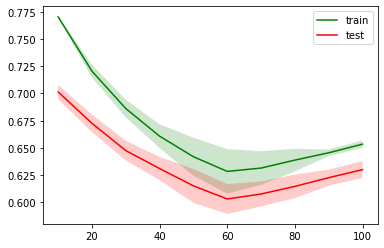

In [48]:
 plot_validation_curves(knn_params['n_neighbors'], knn_grid_searcher.cv_results_)

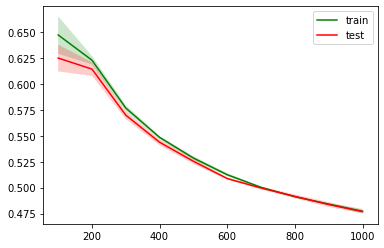

In [50]:
 plot_validation_curves(knn_params['n_neighbors'], knn_grid_searcher.cv_results_)

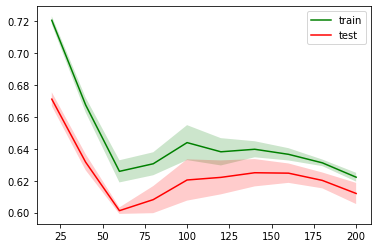

In [52]:
plot_validation_curves(knn_params['n_neighbors'], knn_grid_searcher.cv_results_)

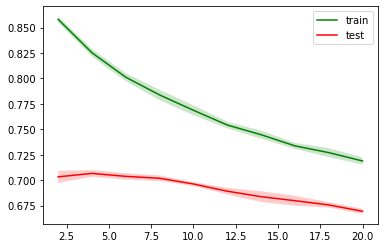

In [24]:
plot_validation_curves(knn_params['n_neighbors'], knn_grid_searcher.cv_results_)

In [25]:
print ('Лучшее количество соседей: {:d}'.format(knn_grid_searcher.best_params_['n_neighbors']))

Лучшее количество соседей: 4


In [26]:
scores_df = get_scores(knn_grid_searcher, 'knn_4')

In [27]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
knn_4,0.707,0.738,0.676,0.913,0.687,0.674


## 2. Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()

In [30]:
%%time
forest_params = {'n_estimators': np.arange(50, 151, 10)}
forest_grid_searcher = GridSearchCV(forest, forest_params, scoring='accuracy', cv=skf, n_jobs=5, return_train_score=True)
forest_grid_searcher.fit(X_train, y_train)

Wall time: 2min 24s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=5,
             param_grid={'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150])},
             return_train_score=True, scoring='accuracy')

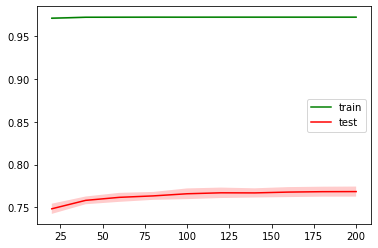

In [29]:
plot_validation_curves(forest_params['n_estimators'], forest_grid_searcher.cv_results_)

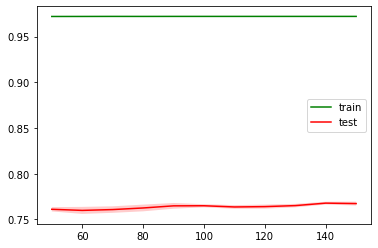

In [31]:
plot_validation_curves(forest_params['n_estimators'], forest_grid_searcher.cv_results_)

In [32]:
print ('Лучшее количество деревьев: {:d}'.format(forest_grid_searcher.best_params_['n_estimators']))

Лучшее количество деревьев: 140


In [33]:
scores_df = scores_df.append(get_scores(forest_grid_searcher, 'random_forest_140'))

In [34]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
knn_4,0.707,0.738,0.676,0.913,0.687,0.674
random_forest_140,0.768,0.781,0.715,0.966,0.751,0.695


## 3. Logistic Regression

In [42]:
logit = LogisticRegression(multi_class='multinomial')

In [49]:
%%time
logit_params = {'C': np.linspace(0.1, 10, 20), 'max_iter': [1000]}
logit_grid_searcher = GridSearchCV(logit, logit_params, scoring='accuracy', cv=skf, n_jobs=5, return_train_score=True)
logit_grid_searcher.fit(X_train, y_train)

Wall time: 2min 20s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=LogisticRegression(multi_class='multinomial'), n_jobs=5,
             param_grid={'C': array([ 0.1       ,  0.62105263,  1.14210526,  1.66315789,  2.18421053,
        2.70526316,  3.22631579,  3.74736842,  4.26842105,  4.78947368,
        5.31052632,  5.83157895,  6.35263158,  6.87368421,  7.39473684,
        7.91578947,  8.43684211,  8.95789474,  9.47894737, 10.        ]),
                         'max_iter': [1000]},
             return_train_score=True, scoring='accuracy')

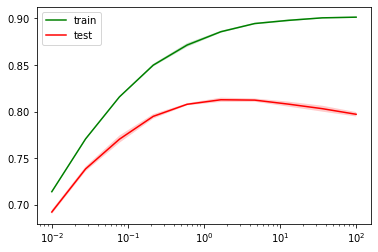

In [45]:
plt.xscale('log')
plot_validation_curves(logit_params['C'], logit_grid_searcher.cv_results_)

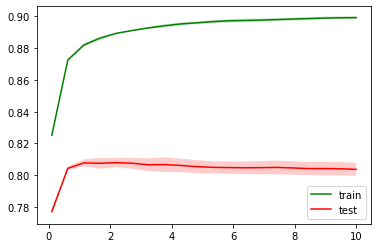

In [50]:
plot_validation_curves(logit_params['C'], logit_grid_searcher.cv_results_)

In [51]:
print ('Лучший C: {:.3f}'.format(logit_grid_searcher.best_params_['C']))

Лучший C: 2.184


In [52]:
scores_df = scores_df.append(get_scores(logit_grid_searcher, 'logit'))

In [53]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
knn_4,0.707,0.738,0.676,0.913,0.687,0.674
random_forest_140,0.768,0.781,0.715,0.966,0.751,0.695
logit,0.808,0.830,0.778,0.981,0.806,0.761


In [54]:
logit_wb = LogisticRegression(multi_class='multinomial', class_weight='balanced')

In [59]:
%%time
logit_wb_params = {'C': np.linspace(0.01, 10, 20), 'max_iter': [1000]}
logit_wb_grid_searcher = GridSearchCV(logit_wb, logit_wb_params, scoring='accuracy', cv=skf, n_jobs=5, return_train_score=True)
logit_wb_grid_searcher.fit(X_train, y_train)

Wall time: 2min 16s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          multi_class='multinomial'),
             n_jobs=5,
             param_grid={'C': array([ 0.01      ,  0.53578947,  1.06157895,  1.58736842,  2.11315789,
        2.63894737,  3.16473684,  3.69052632,  4.21631579,  4.74210526,
        5.26789474,  5.79368421,  6.31947368,  6.84526316,  7.37105263,
        7.89684211,  8.42263158,  8.94842105,  9.47421053, 10.        ]),
                         'max_iter': [1000]},
             return_train_score=True, scoring='accuracy')

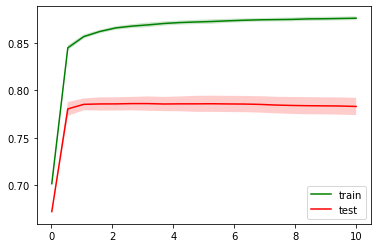

In [60]:
plot_validation_curves(logit_wb_params['C'], logit_wb_grid_searcher.cv_results_)

In [61]:
print ('Лучший C: {:.3f}'.format(logit_grid_searcher.best_params_['C']))

Лучший C: 2.184


In [62]:
scores_df = scores_df.append(get_scores(logit_wb_grid_searcher, 'logit_wb'))

In [70]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
model,,,,,,
knn_4,0.707,0.738,0.676,0.913,0.687,0.674
random_forest_140,0.768,0.781,0.715,0.966,0.751,0.695
logit,0.808,0.830,0.778,0.981,0.806,0.761
logit_wb,0.786,0.808,0.772,0.980,0.767,0.791


## 4. Linear SVM

In [72]:
svm = LinearSVC()

In [84]:
%%time
svm_params = {'C': np.linspace(0.05, 1, 20), 'max_iter': [3000]}
svm_grid_searcher = GridSearchCV(svm, svm_params, scoring='accuracy', cv=skf, n_jobs=5, return_train_score=True)
svm_grid_searcher.fit(X_train, y_train)

Wall time: 38.8 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=LinearSVC(), n_jobs=5,
             param_grid={'C': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                         'max_iter': [3000]},
             return_train_score=True, scoring='accuracy')

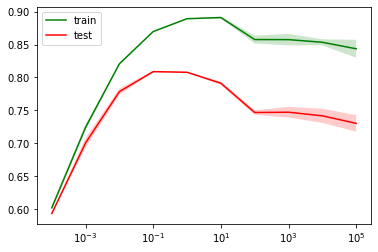

In [75]:
plt.xscale('log')
plot_validation_curves(svm_params['C'], svm_grid_searcher.cv_results_)

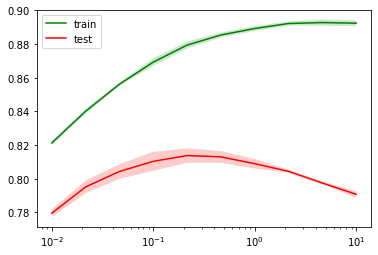

In [77]:
plt.xscale('log')
plot_validation_curves(svm_params['C'], svm_grid_searcher.cv_results_)

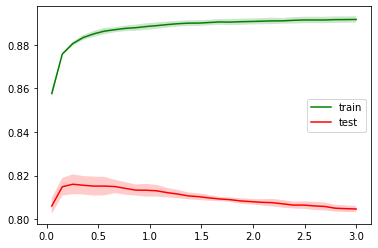

In [81]:
plot_validation_curves(svm_params['C'], svm_grid_searcher.cv_results_)

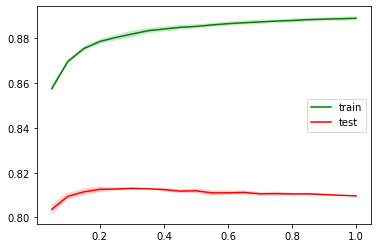

In [85]:
plot_validation_curves(svm_params['C'], svm_grid_searcher.cv_results_)

In [86]:
print ('Лучший C: {:.3f}'.format(svm_grid_searcher.best_params_['C']))

Лучший C: 0.300


In [89]:
scores_df = scores_df.append(get_scores(svm_grid_searcher, 'svm', proba=False))

In [90]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
knn_4,0.707,0.738,0.676,0.913,0.687,0.674
random_forest_140,0.768,0.781,0.715,0.966,0.751,0.695
logit,0.808,0.830,0.778,0.981,0.806,0.761
logit_wb,0.786,0.808,0.772,0.980,0.767,0.791
svm,0.813,0.831,0.781,NaN,0.813,0.761


In [91]:
svm_wb = LinearSVC(class_weight='balanced')

In [98]:
%%time
svm_wb_params = {'C': np.linspace(0.01, 1, 10), 'max_iter': [5000]}
svm_wb_grid_searcher = GridSearchCV(svm_wb, svm_wb_params, scoring='accuracy', cv=skf, n_jobs=5, return_train_score=True)
svm_wb_grid_searcher.fit(X_train, y_train)

Wall time: 27.9 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=LinearSVC(class_weight='balanced'), n_jobs=5,
             param_grid={'C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'max_iter': [5000]},
             return_train_score=True, scoring='accuracy')

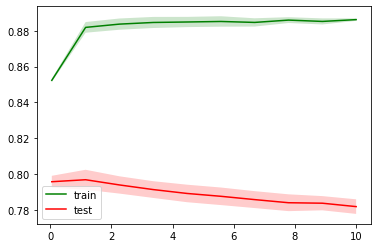

In [95]:
plot_validation_curves(svm_wb_params['C'], svm_wb_grid_searcher.cv_results_)

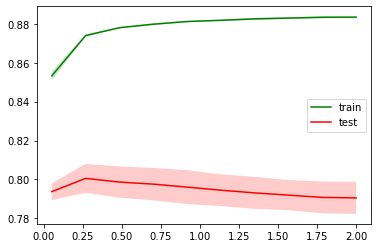

In [97]:
plot_validation_curves(svm_wb_params['C'], svm_wb_grid_searcher.cv_results_)

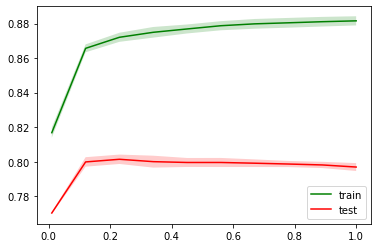

In [99]:
plot_validation_curves(svm_wb_params['C'], svm_wb_grid_searcher.cv_results_)

In [100]:
print ('Лучший C: {:.3f}'.format(svm_grid_searcher.best_params_['C']))

Лучший C: 0.300


In [101]:
scores_df = scores_df.append(get_scores(svm_wb_grid_searcher, 'svm_wb', proba=False))

In [108]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
knn_4,0.707,0.738,0.676,0.913,0.687,0.674
random_forest_140,0.768,0.781,0.715,0.966,0.751,0.695
logit,0.808,0.830,0.778,0.981,0.806,0.761
logit_wb,0.786,0.808,0.772,0.980,0.767,0.791
svm,0.813,0.831,0.781,NaN,0.813,0.761
svm_wb,0.801,0.820,0.779,NaN,0.784,0.782


In [109]:
scores_df.to_csv('scores_df.csv')

## 5. SGD Classifier (SVM)

In [17]:
from sklearn.linear_model import SGDClassifier

In [10]:
sgd_logit = SGDClassifier('log')

In [20]:
%%time
sgd_logit_params = {'alpha': np.linspace(5e-7, 2e-4, 30)}
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, sgd_logit_params, scoring='accuracy', cv=skf, n_jobs=5, 
                                       return_train_score=True)
sgd_logit_grid_searcher.fit(X_train, y_train)

Wall time: 8.69 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=SGDClassifier(loss='log'), n_jobs=5,
             param_grid={'alpha': array([5.00000000e-07, 7.37931034e-06, 1.42586207e-05, 2.11379310e-05,
       2.80172414e-05, 3.48965517e-05, 4.17758621e-05, 4.86551724e-05,
       5.55344828e-05, 6.24137931e-05, 6.92931034e-05, 7.61724138e-05,
       8.30517241e-05, 8.99310345e-05, 9.68103448e-05, 1.03689655e-04,
       1.10568966e-04, 1.17448276e-04, 1.24327586e-04, 1.31206897e-04,
       1.38086207e-04, 1.44965517e-04, 1.51844828e-04, 1.58724138e-04,
       1.65603448e-04, 1.72482759e-04, 1.79362069e-04, 1.86241379e-04,
       1.93120690e-04, 2.00000000e-04])},
             return_train_score=True, scoring='accuracy')

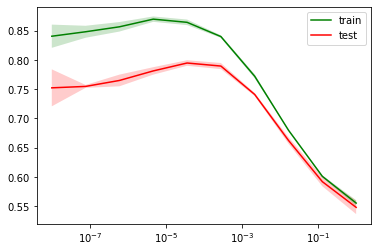

In [11]:
plt.xscale('log')
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_)

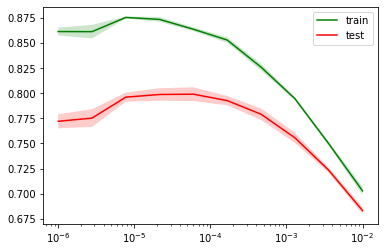

In [13]:
plt.xscale('log')
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_)

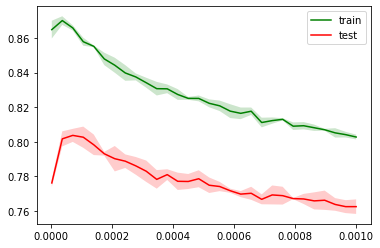

In [15]:
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_)

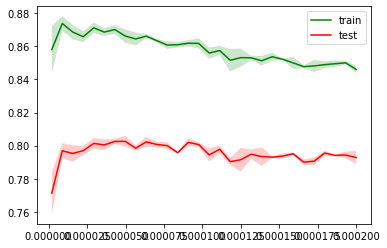

In [17]:
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_)

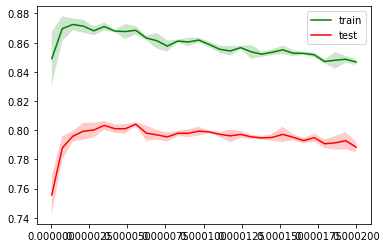

In [19]:
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_)

In [21]:
print ('Лучший alpha: {:.3e}'.format(sgd_logit_grid_searcher.best_params_['alpha']))

Лучший alpha: 5.553e-05


In [21]:
scores_df = pd.read_csv('scores_df.csv', index_col=0)

In [23]:
scores_df = scores_df.append(get_scores(sgd_logit_grid_searcher, 'sgd_logit'))

In [24]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
knn_4,0.707,0.738,0.676,0.913,0.687,0.674
random_forest_140,0.768,0.781,0.715,0.966,0.751,0.695
logit,0.808,0.830,0.778,0.981,0.806,0.761
logit_wb,0.786,0.808,0.772,0.980,0.767,0.791
svm,0.813,0.831,0.781,NaN,0.813,0.761
svm_wb,0.801,0.820,0.779,NaN,0.784,0.782
sgd_logit,0.808,0.811,0.762,0.976,0.789,0.744


# Эксперименты с данными и признаками

Возьмем мешок слов и будем отрезать от него самые частые и самые редкие слова

In [18]:
sgd_logit = SGDClassifier('log', alpha=5.553e-05)

In [81]:
def select_sites_in_sparse(often_range, rare_range):
    
    def plot_scores(x_range, cut_type):
        if cut_type=='often': axis = 1
        else: axis = 0
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))
        fig.suptitle(cut_type, fontsize=16)
        axes[0, 0].plot(x_range, train_accuracy.mean(axis=axis), label='train', color='r')
        axes[0, 0].legend()
        axes[0, 1].plot(x_range, cv_accuracy.mean(axis=axis), label='cv', color='g')
        axes[0, 1].legend()
        axes[0, 2].plot(x_range, holdout_accuracy.mean(axis=axis), label='test', color='b')
        axes[0, 2].legend()
        axes[1, 0].plot(x_range, f1.mean(axis=axis), label='f1', color='y')
        axes[1, 0].legend()
        axes[1, 1].plot(x_range, roc_auc.mean(axis=axis), label='roc_auc', color='c')
        axes[1, 1].legend()
        axes[1, 2].remove()
        
    cv_accuracy = []
    train_accuracy = []
    holdout_accuracy = []
    f1 = []
    roc_auc = []
    for often, rare in tqdm(list(itertools.product(often_range, rare_range))):
        X = X_sparse_10users[:, often:-rare]
        X_train, X_valid, y_train, y_valid = train_test_split(X, y_10users, test_size=0.3, stratify=y_10users)
        cv_accuracy.append(cross_val_score(sgd_logit, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=5).mean())
        sgd_logit.fit(X_train, y_train)
        train_accuracy.append(accuracy_score(y_train, sgd_logit.predict(X_train)))
        holdout_accuracy.append(accuracy_score(y_valid, sgd_logit.predict(X_valid)))
        f1.append(f1_score(y_valid, sgd_logit.predict(X_valid), average='macro'))
        roc_auc.append(roc_auc_score(y_valid, sgd_logit.predict_proba(X_valid), average='macro', multi_class='ovr'))

    train_accuracy = np.array(train_accuracy).reshape((len(often_range), len(rare_range)))
    cv_accuracy = np.array(cv_accuracy).reshape((len(often_range), len(rare_range)))
    holdout_accuracy = np.array(holdout_accuracy).reshape((len(often_range), len(rare_range)))
    f1 = np.array(f1).reshape((len(often_range), len(rare_range)))
    roc_auc = np.array(roc_auc).reshape((len(often_range), len(rare_range)))
    
    plot_scores(often_range, 'often')
    plot_scores(rare_range, 'rare')
    plt.show()

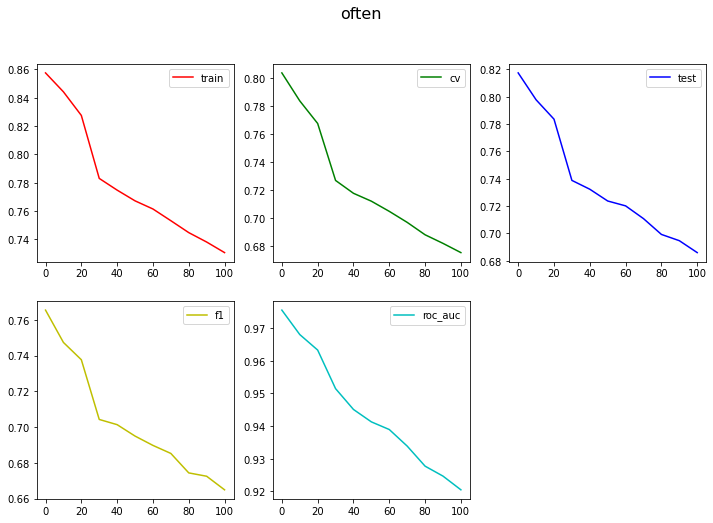

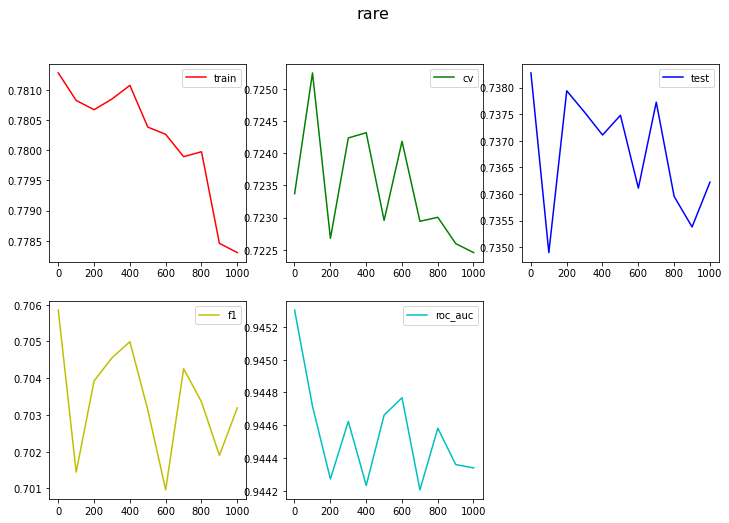

In [82]:
select_sites_in_sparse(range(0, 101, 10), range(1, 1002, 100))

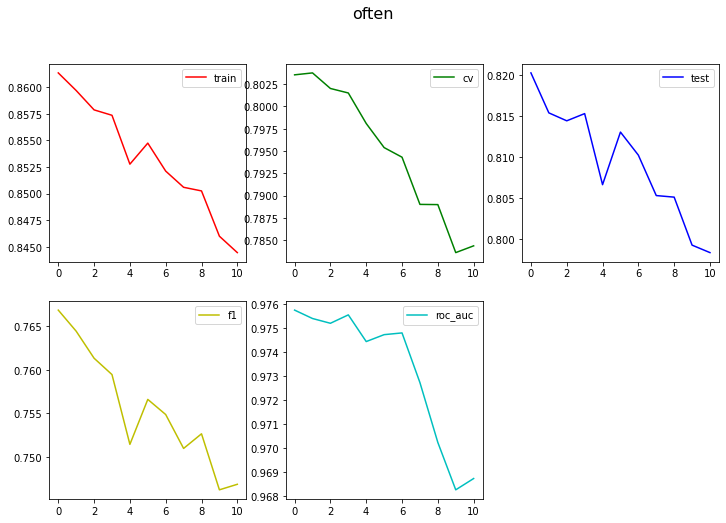

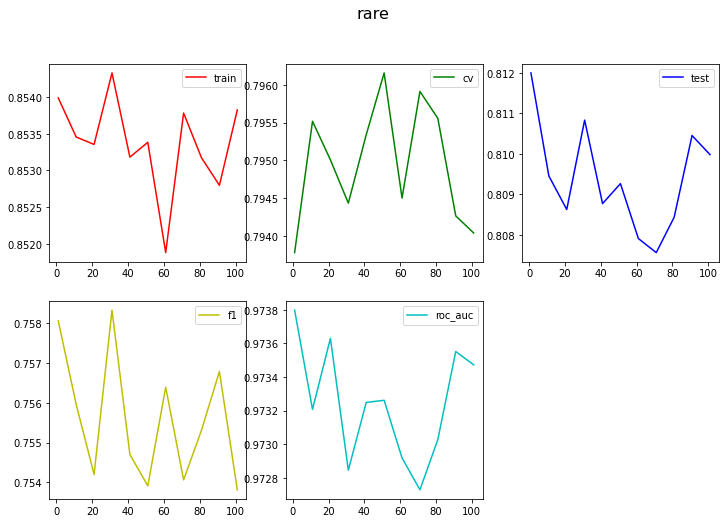

In [83]:
select_sites_in_sparse(range(0, 11), range(1, 102, 10))

Вывод: Удаление частых слов резко ухудшает модель, а удаление редких слов никак не влияет.

In [32]:
data = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), index_col=0)

In [33]:
data = data.iloc[:, :15].apply(lambda row: ' '.join([str(x) for x in row]), axis=1)

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(data, y_10users, test_size=0.3, stratify=y_10users)

In [37]:
pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                ('classifier', sgd_logit)])

In [35]:
param_grid = {'vectorizer__min_df': range(1, 202, 20),
             'vectorizer__max_df': range(2000, 9001, 1000),
             'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

In [38]:
%%time
pipe_grid_searcher = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=skf, n_jobs=5, 
                                       return_train_score=True)
pipe_grid_searcher.fit(X_train, y_train)

Wall time: 1min 48s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        SGDClassifier(alpha=5.553e-05,
                                                      loss='log'))]),
             n_jobs=5,
             param_grid={'vectorizer__max_df': range(2000, 9001, 1000),
                         'vectorizer__min_df': range(1, 202, 20),
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             return_train_score=True, scoring='accuracy')

In [39]:
pipe_grid_searcher.best_score_

0.8333333333333334

In [40]:
pipe_grid_searcher.best_params_

{'vectorizer__max_df': 6000,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 3)}

In [49]:
param_grid = {'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

In [50]:
%%time
pipe_grid_searcher = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=skf, n_jobs=5, 
                                       return_train_score=True)
pipe_grid_searcher.fit(X_train, y_train)

Wall time: 4.64 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        SGDClassifier(alpha=5.553e-05,
                                                      loss='log'))]),
             n_jobs=5,
             param_grid={'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             return_train_score=True, scoring='accuracy')

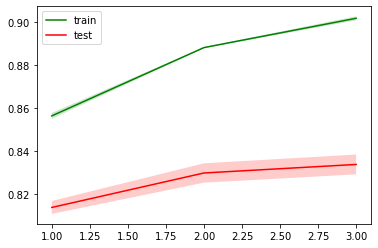

In [51]:
plot_validation_curves(range(1, 4), pipe_grid_searcher.cv_results_)

In [52]:
param_grid = {'vectorizer__max_df': range(2000, 9001, 1000)}

In [53]:
%%time
pipe_grid_searcher = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=skf, n_jobs=5, 
                                       return_train_score=True)
pipe_grid_searcher.fit(X_train, y_train)

Wall time: 2.66 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        SGDClassifier(alpha=5.553e-05,
                                                      loss='log'))]),
             n_jobs=5,
             param_grid={'vectorizer__max_df': range(2000, 9001, 1000)},
             return_train_score=True, scoring='accuracy')

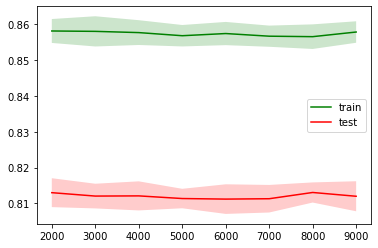

In [54]:
plot_validation_curves(param_grid['vectorizer__max_df'], pipe_grid_searcher.cv_results_)

In [57]:
param_grid = {'vectorizer__max_df': range(2000, 9001, 1000),
             'vectorizer__ngram_range': [(1, 3)]}

In [58]:
%%time
pipe_grid_searcher = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=skf, n_jobs=5, 
                                       return_train_score=True)
pipe_grid_searcher.fit(X_train, y_train)

Wall time: 7.52 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        SGDClassifier(alpha=5.553e-05,
                                                      loss='log'))]),
             n_jobs=5,
             param_grid={'vectorizer__max_df': range(2000, 9001, 1000),
                         'vectorizer__ngram_range': [(1, 3)]},
             return_train_score=True, scoring='accuracy')

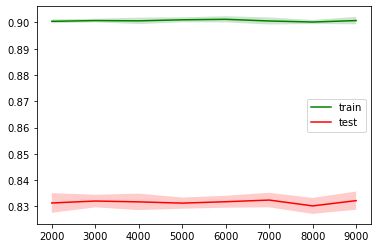

In [59]:
plot_validation_curves(param_grid['vectorizer__max_df'], pipe_grid_searcher.cv_results_)

In [60]:
param_grid = {'vectorizer__min_df': range(1, 202, 20),
             'vectorizer__ngram_range': [(1, 3)]}

In [61]:
%%time
pipe_grid_searcher = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=skf, n_jobs=5, 
                                       return_train_score=True)
pipe_grid_searcher.fit(X_train, y_train)

Wall time: 7.48 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        SGDClassifier(alpha=5.553e-05,
                                                      loss='log'))]),
             n_jobs=5,
             param_grid={'vectorizer__min_df': range(1, 202, 20),
                         'vectorizer__ngram_range': [(1, 3)]},
             return_train_score=True, scoring='accuracy')

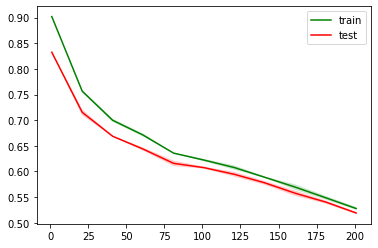

In [62]:
plot_validation_curves(param_grid['vectorizer__min_df'], pipe_grid_searcher.cv_results_)

In [63]:
param_grid = {'vectorizer__min_df': range(1, 20),
             'vectorizer__ngram_range': [(1, 3)]}

In [64]:
%%time
pipe_grid_searcher = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=skf, n_jobs=5, 
                                       return_train_score=True)
pipe_grid_searcher.fit(X_train, y_train)

Wall time: 12.8 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        SGDClassifier(alpha=5.553e-05,
                                                      loss='log'))]),
             n_jobs=5,
             param_grid={'vectorizer__min_df': range(1, 20),
                         'vectorizer__ngram_range': [(1, 3)]},
             return_train_score=True, scoring='accuracy')

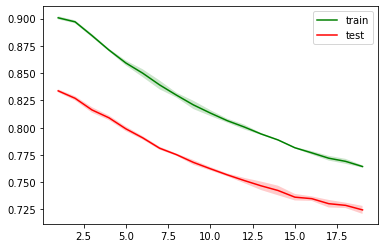

In [65]:
plot_validation_curves(param_grid['vectorizer__min_df'], pipe_grid_searcher.cv_results_)

In [66]:
pipe.set_params(vectorizer__ngram_range=(1, 3))

Pipeline(steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 3))),
                ('classifier', SGDClassifier(alpha=5.553e-05, loss='log'))])

In [69]:
scores_df = scores_df.append(get_scores_point(pipe, 'sgd_logit_tfidf'))

In [70]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
knn_4,0.707,0.738,0.676,0.913,0.687,0.674
random_forest_140,0.768,0.781,0.715,0.966,0.751,0.695
logit,0.808,0.830,0.778,0.981,0.806,0.761
logit_wb,0.786,0.808,0.772,0.980,0.767,0.791
svm,0.813,0.831,0.781,NaN,0.813,0.761
svm_wb,0.801,0.820,0.779,NaN,0.784,0.782
sgd_logit,0.808,0.811,0.762,0.976,0.789,0.744
sgd_logit_tfidf,0.832,0.833,0.783,0.975,0.852,0.749


In [71]:
scores_df.to_csv('scores_df.csv')

## Bag + features

In [2]:
def load_data(path_to_df, path_to_feats):
    df_feats = pd.read_csv(path_to_feats, index_col=0)
    df_feats['sess_timespan_flag'] = [0]*df_feats.shape[0]
    df_feats['top_sites_time_flag'] = [0]*df_feats.shape[0]
    df_feats.loc[df_feats.session_timespan>200, 'sess_timespan_flag'] = 1
    df_feats.loc[df_feats.top_sites_time>400, 'top_sites_time_flag'] = 1
    df = pd.read_csv(path_to_df, index_col=0)
    return pd.concat((df, df_feats), axis=1)

In [6]:
df = load_data(os.path.join(PATH_TO_DATA, 'train_data_10users.csv'), os.path.join(PATH_TO_DATA, 'new_features_10users.csv'))

In [7]:
y_10users = df['user_id']
X = df.drop(['user_id'], axis=1)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_10users, 
                                                      test_size=0.3, stratify=y_10users)

In [9]:
bag_of_sites = ['site'+str(i) for i in range(1, 16)]
is_top_feats = ['is_top'+str(i) for i in range(1, 31)]
categorical_feats = ['start_hour', 'day_of_week', 'day', 'time_of_day']
binary_feats = ['fcbk_fr_flag', 'sess_timespan_flag', 'top_sites_time_flag']
numerical_feats = ['session_timespan', 'unique_sites', 'top_sites_time', 'facebook_freq']

In [10]:
log_preprocessor = ColumnTransformer([
    ('log_scaling', FunctionTransformer(lambda data: np.log(data+0.01)), 
     ['session_timespan', 'top_sites_time', 'facebook_freq'])
],
remainder='passthrough')

In [19]:
pipeline = Pipeline(steps=[
    ('feature_processing', FeatureUnion(transformer_list=[
        ('binary_variables', FunctionTransformer(lambda data: data.loc[:, binary_feats])),
        ('categorical_variables', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, categorical_feats])),
            ('hot_encoding', OneHotEncoder(handle_unknown='ignore'))
        ])),
        ('bag_of_sites', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, bag_of_sites].apply(lambda row: \
                                                                        ' '.join([str(x) for x in row]), axis=1))),
            ('vectorizer', TfidfVectorizer())
        ])),
        ('is_top_site', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, is_top_feats])),
            ('dim_reducing', TruncatedSVD(10))
        ])),
        ('numerical_variables', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, numerical_feats])),
            ('log_preprocessing', log_preprocessor),
            ('scaling', StandardScaler())
        ]))
    ])),
    ('classifier', sgd_logit)
])

In [24]:
%%time
scores_df = scores_df.append(get_scores_point(pipeline, 'pipe_sgd_logit'))

Wall time: 4.67 s


In [25]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
knn_4,0.707,0.738,0.676,0.913,0.687,0.674
random_forest_140,0.768,0.781,0.715,0.966,0.751,0.695
logit,0.808,0.830,0.778,0.981,0.806,0.761
logit_wb,0.786,0.808,0.772,0.980,0.767,0.791
svm,0.813,0.831,0.781,NaN,0.813,0.761
svm_wb,0.801,0.820,0.779,NaN,0.784,0.782
sgd_logit,0.808,0.811,0.762,0.976,0.789,0.744
sgd_logit_tfidf,0.832,0.833,0.783,0.975,0.852,0.749
pipe_sgd_logit,0.898,0.906,0.884,0.990,0.894,0.877


<AxesSubplot:>

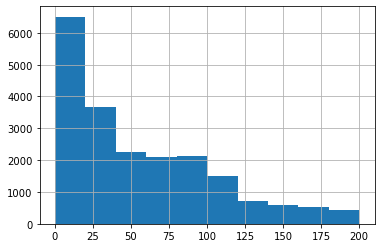

In [11]:
df_feats.session_timespan.hist(range=[0, 200])

<AxesSubplot:>

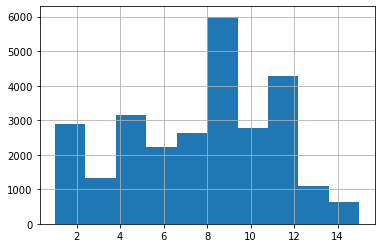

In [13]:
df_feats.unique_sites.hist()

<AxesSubplot:>

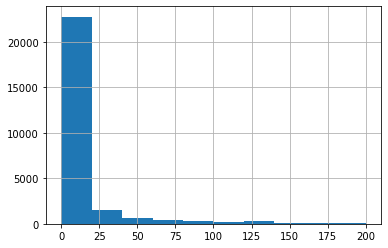

In [18]:
df_feats.top_sites_time.hist(range=[0, 200])

<AxesSubplot:>

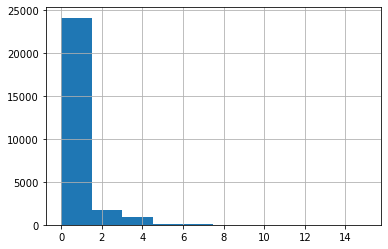

In [37]:
df_feats.facebook_freq.hist()

In [65]:
df_150 = load_data(os.path.join(PATH_TO_DATA, 'train_data_150users.csv'), 
                   os.path.join(PATH_TO_DATA, 'new_features_150users.csv'))

In [66]:
y = df_150['user_id']
X = df_150.drop(['user_id'], axis=1)

In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y)

In [68]:
%%time
scores_df = scores_df.append(get_scores_point(pipeline, 'pipe_150users'))

Wall time: 1min 47s


In [69]:
scores_df

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
knn_4,0.707,0.738,0.676,0.913,0.687,0.674
random_forest_140,0.768,0.781,0.715,0.966,0.751,0.695
logit,0.808,0.830,0.778,0.981,0.806,0.761
logit_wb,0.786,0.808,0.772,0.980,0.767,0.791
svm,0.813,0.831,0.781,NaN,0.813,0.761
svm_wb,0.801,0.820,0.779,NaN,0.784,0.782
sgd_logit,0.808,0.811,0.762,0.976,0.789,0.744
sgd_logit_tfidf,0.832,0.833,0.783,0.975,0.852,0.749
pipe_sgd_logit,0.896,0.901,0.882,0.990,0.891,0.875
pipe_150users,0.541,0.544,0.494,0.967,0.545,0.483
